EDA

Our main objective is to answer key questions about the usage of landcover data:

1) How the landcover categories are distributed among frames?
2) How the landcover categories correlate with deforestation?

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from shapely.geometry import box

import config
from utils import compute_frames

In [2]:
# load frames deforestation area history
deforestation = pd.read_csv(config.TR_DEFORESTATION, index_col=0)
deforestation["quarter_date"] = pd.to_datetime(deforestation["quarter_date"])

In [3]:
# landcover (with types as columns)
landcover = pd.read_csv(config.TR_LANDCOVER)
landcover = pd.pivot_table(
    landcover, 
    index=["frame_id"], 
    columns=["landcover"], 
    values="geometry", 
    aggfunc="sum"
).fillna(0).astype(int)

In [4]:
# convert to percentage
sum_by_frame = landcover.sum(axis=1)
for col in landcover.columns:
    landcover[col] = landcover[col] / sum_by_frame

In [5]:
m = pd.merge(
    deforestation,
    landcover[col].reset_index(),
    on="frame_id",
    how="left",
    validate="m:1"
)
m[m[col] == 0]["area"].count(), m[m[col] > 0]["area"].count()

(265447, 8)

<Axes: xlabel='220', ylabel='area'>

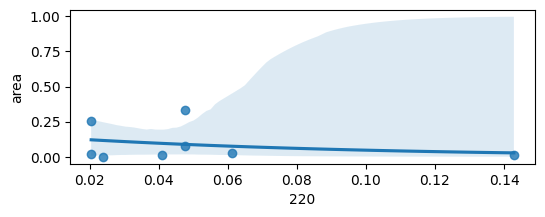

In [7]:
fig, ax = plt.subplots(figsize=(6, 2))
X = m[m[col] > 0].dropna()
sns.regplot(
    x=X[col], 
    y=X["area"],
    logistic=True,
    ax=ax
)


+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Landcover type ID     : 20
% of zeros            : 69.46%
Average frame coverage: 5.80%


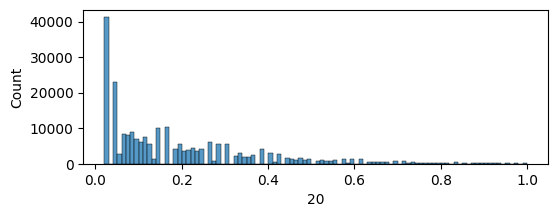

Frames with landcover 20: 93084 (34.98%)
Deforestation area with landcover   : 0.04232462975774288
Deforestation area without landcover: 0.06685883487475505


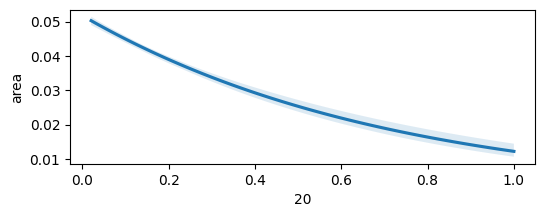


+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Landcover type ID     : 40
% of zeros            : 16.79%
Average frame coverage: 62.95%


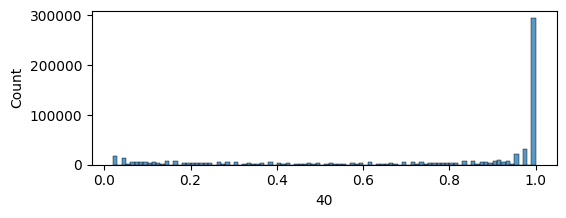

Frames with landcover 40: 263575 (99.05%)
Deforestation area with landcover   : 0.05748299631575927
Deforestation area without landcover: 0.16659005778717756


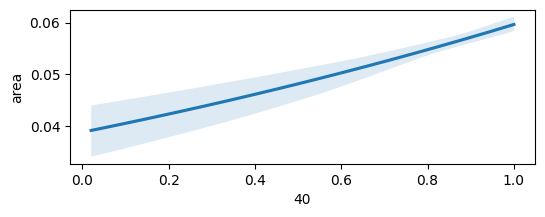


+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Landcover type ID     : 50
% of zeros            : 87.67%
Average frame coverage: 2.20%


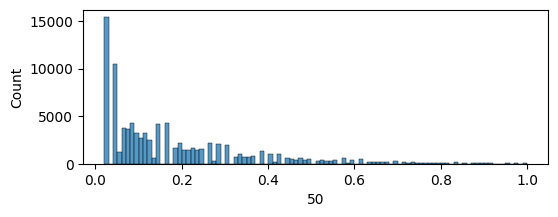

Frames with landcover 50: 11953 (4.49%)
Deforestation area with landcover   : 0.09855741063602996
Deforestation area without landcover: 0.056355426518266825


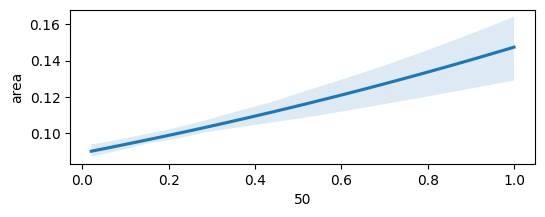


+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Landcover type ID     : 180
% of zeros            : 90.34%
Average frame coverage: 1.76%


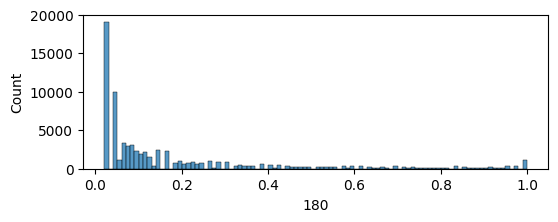

Frames with landcover 180: 12484 (4.69%)
Deforestation area with landcover   : 0.07181683625561386
Deforestation area without landcover: 0.057586477022073895


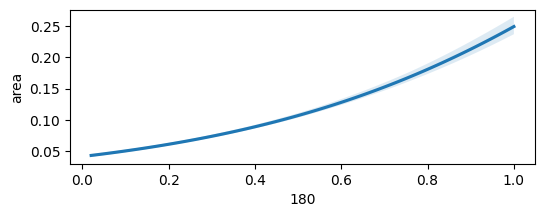

In [19]:
for col in [20, 40, 50, 180]:  # landcover.columns:
    print("\n+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+")
    print(f"Landcover type ID     : {col}")
    print(f"% of zeros            : {100*(landcover[col]==0).mean():.2f}%")
    print(f"Average frame coverage: {100*(landcover[col]).mean():.2f}%")
    fig, ax = plt.subplots(figsize=(6, 2))
    sns.histplot(landcover[landcover[col]>0][col], binwidth=0.01, ax=ax)
    plt.show()

    m = pd.merge(
        deforestation,
        landcover[col].reset_index(),
        on="frame_id",
        how="left",
        validate="m:1"
    )
    print(f"Frames with landcover {col}: {m[m[col] > 0]['area'].count()} ({100*m[m[col] > 0]['area'].count()/m.shape[0]:.2f}%)")
    print(f"Deforestation area with landcover   : {m[m[col] > 0]['area'].mean()}")
    print(f"Deforestation area without landcover: {m[m[col] == 0]['area'].mean()}")
    fig, ax = plt.subplots(figsize=(6, 2))
    X = m[m[col] > 0].dropna()
    if len(X) > 3e4:
        X = X.sample(int(3e4))
    sns.regplot(
        x=X[col], 
        y=X["area"],
        logistic=True,
        ax=ax,
        n_boot=100,
        scatter=False
    )
    plt.show()

Landcover types that shows most clear relations: 
- 20: Mosaic cropland (50-70%) / vegetation (grassland, shrubland, forest) (20-50%)
- 40: Closed to open (>15%) broadleaved evergreen and/or semi-deciduous forest (>5m)
- 50: Closed (>40%) broadleaved deciduous forest (>5m)
- 180: Closed to open (>15%) vegetation (grassland, shrubland, woody vegetation) on regularly flooded or waterlogged soil - fresh, brackish or saline water

40 and 50 seems to be close categories! We can use them as one feature.

In [20]:
landcover[[20, 40, 50, 180]]

landcover,20,40,50,180
frame_id,,,,
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0
...,...,...,...,...
765546,0.0,0.0,0.0,0.0
765547,0.0,0.0,0.0,0.0
765548,0.0,0.0,0.0,0.0
